<a href="https://colab.research.google.com/github/annasli378/Fat-Cells-Morphology/blob/main/fatcells_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTS
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import cv2,sys
from tqdm import tqdm
import scipy.io as sio
from scipy.spatial import Delaunay, delaunay_plot_2d, Voronoi, voronoi_plot_2d

# FUNCTIONS FROM REPOSITORY (WITH SOME CHANGES):
https://github.com/abebe9849/Crohn_wsi


In [12]:
def water_shed(gray_img,color_img,p=0.1):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    sure_bg = cv2.dilate(gray_img, kernel, iterations=2)## はいぱら
    dist = cv2.distanceTransform(gray_img, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist, p * dist.max(), 255, cv2.THRESH_BINARY)
    sure_fg = sure_fg.astype(np.uint8)
    unknown = cv2.subtract(sure_bg, sure_fg)
    n_labels, markers = cv2.connectedComponents(sure_fg)
    markers += 1
    markers[unknown == 255] = 0
    markers = cv2.watershed(color_img, markers)
    return markers

def img_and(mask,canny):  # uint8 ndarray0~255
    canny = (255-canny)/255
    mask = mask/255
    new_img = np.logical_and(canny,mask)
    return new_img

def each_cell_vori(markers,thresh=0.03,plot=True):
    u, counts = np.unique(markers.ravel(), return_counts=True)
    areas = []
    emp = np.zeros_like(markers)
    margin_num = 0
    points = []
    ellipses  = []
    ellipses_rate = []
    emp_2 = np.zeros_like(markers)

    for cls,s in zip(u,counts):
        if cls<0:
            tmp_img = (markers == cls)

            continue#枠(-1)
        if s<500:continue
        if s >1024*1024*thresh:
            if plot:
                tmp_img = (markers == cls)

            margin_num+=1
            continue
        tmp_img = (markers == cls)
        emp[np.where(markers == cls)]=cls
        emp_2[np.where(markers == cls)]=cls
        mu = cv2.moments(emp_2.astype("uint8"), False)
        try:
            x,y= int(mu["m10"]/mu["m00"]) , int(mu["m01"]/mu["m00"])
            points.append([x,y])
        except Exception as e:
            print("center not...")
            x,y = (0,0)
            points.append([x,y])

        contours, hierarchy = cv2.findContours(emp_2.astype("uint8"),cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        mx_area = 0
        for cont in contours:
            x_,y_,w,h = cv2.boundingRect(cont)
            area = w*h
            if area > mx_area:
                mx_area = area
                if area<10 or len(cont)<5:continue
                try:
                    ellipse = cv2.fitEllipse(cont)
                except Exception as e:
                    print(len(cont))

        try:
            ellipses.append([ellipse[1][0],ellipse[1][1]])
            ellipses_rate.append(ellipse[1][0]/ellipse[1][1])##h/w
        except Exception as e:
            print(e)
        emp_2 = cv2.circle(emp_2, (x,y), 4, 100, 2, 4)
        emp_2[np.where(markers == cls)]=0

        if cls%200==0 and plot:
            plt.title(f"class{cls} area{s}")
            plt.imshow(tmp_img)
            plt.show()
        areas.append(s)
    back_area = counts[2]

    for xy in  points:
        x = xy[0]
        y =xy[1]
        emp = cv2.circle(emp, (x,y), 4, 100, 2, 4)

    norms = []
    try:
        tri = Delaunay(points)
        tri_points = tri.points

        for i in range(len(tri_points)):
            for j in range(i,len(tri_points)):
                if i==j:continue
                x_i = tri_points[i][0]
                y_i = tri_points[i][1]
                x_j = tri_points[j][0]
                y_j = tri_points[j][1]
                nolm = ((x_i-x_j)**2+(y_i-y_j)**2)**0.5
                norms.append(nolm)
    except Exception as e:
        plt.imshow(emp)
        plt.savefig("error.png")
        plt.imshow(markers)
        plt.savefig("error1.png")
    return emp,areas,back_area,margin_num,norms,ellipses_rate

def margin_to_black_plus(markers,color_img,gray_img,distant=None,p=0.1,thresh = 0.03,thresh_margin=0.05,plot=False):
    u, counts = np.unique(markers.ravel(), return_counts=True)
    points = []##ボロノイ分割よう
    ellipses  = []
    ellipses_rate = []
    emp_2 = np.zeros_like(markers)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    sure_bg = cv2.dilate(gray_img, kernel, iterations=2)## はいぱら
    if distant is None:

        dist = cv2.distanceTransform(gray_img, cv2.DIST_L2, 5)
        ret, sure_fg = cv2.threshold(dist, p * dist.max(), 255, cv2.THRESH_BINARY)
    else:
        dist = cv2.distanceTransform(distant, cv2.DIST_L2, 5)
        ret, sure_fg = cv2.threshold(dist, p * dist.max()*0.05, 255, cv2.THRESH_BINARY)

    sure_fg = sure_fg.astype(np.uint8)
    unknown = cv2.subtract(sure_bg, sure_fg)
    n_labels, markers = cv2.connectedComponents(sure_fg)
    markers += 1
    markers[unknown == 255] = 0
    markers = cv2.watershed(color_img, markers)

    u, counts = np.unique(markers.ravel(), return_counts=True)
    areas = []
    emp = np.zeros_like(markers)
    margin_num = 0
    for cls,s in zip(u,counts):
        if cls<0:
            continue
        if s<500:continue
        if s >1024*1024*thresh:
            margin_num+=1
            if plot:
                tmp_img = (markers == cls)
                plt.title(f"class{cls} area{s}")
                plt.imshow(tmp_img)
                plt.show()
            continue
        tmp_img = (markers == cls)
        emp[np.where(markers == cls)]=cls
        emp_2[np.where(markers == cls)]=cls
        mu = cv2.moments(emp_2.astype("uint8"), False)

        try:
            x,y= int(mu["m10"]/mu["m00"]) , int(mu["m01"]/mu["m00"])
            points.append([x,y])
        except Exception as e:
            print("center not...")
            x,y = (0,0)
            points.append([x,y])

        contours, hierarchy = cv2.findContours(emp_2.astype("uint8"),cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        mx_area = 0
        for cont in contours:
            x_,y_,w,h = cv2.boundingRect(cont)
            area = w*h
            if area > mx_area:
                mx_area = area
                if area<10 or len(cont)<5:continue
                ellipse = cv2.fitEllipse(cont)
        try:
            ellipses.append([ellipse[1][0],ellipse[1][1]])
        except Exception as e:
            plt.imshow(color_img)
            plt.savefig("error2.png")
            plt.imshow(emp)
            plt.savefig("error.png")
            plt.imshow(gray_img)
            plt.savefig("error3.png")
            sys.exit()

        ellipses_rate.append(ellipse[1][0]/ellipse[1][1])##h/w
        emp_2 = cv2.circle(emp_2, (x,y), 4, 100, 2, 4)
        emp_2[np.where(markers == cls)]=0

        if cls%200==0 and plot:
            plt.title(f"class{cls} area{s}")
            plt.imshow(tmp_img)
            plt.show()
        areas.append(s)
    back_area = counts[2]

    for xy in  points:
        x = xy[0]
        y =xy[1]
        emp = cv2.circle(emp, (x,y), 4, 100, 2, 4)
    norms = []

    try:
        tri = Delaunay(points)
        tri_points = tri.points
        for i in range(len(tri_points)):
            for j in range(i,len(tri_points)):
                if i==j:continue
                x_i = tri_points[i][0]
                y_i = tri_points[i][1]
                x_j = tri_points[j][0]
                y_j = tri_points[j][1]
                nolm = ((x_i-x_j)**2+(y_i-y_j)**2)**0.5
                norms.append(nolm)
    except Exception as e:
        print(len(areas))
    return emp,areas,back_area,margin_num,norms,ellipses_rate

def calc_analyze_plus(path,label,num):
    areas_ = []
    backgrounds = []
    distants = []
    ellipses_rates = []
    for idx in tqdm(range(num)):
        if label==0:
            img = img =cv2.imread(path)
        else:
            img = img =cv2.imread(path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        retval, mask = cv2.threshold(gray, thresh=gray.mean(0).mean(0), maxval=255, type=cv2.THRESH_BINARY)
        markers = water_shed(mask,img)
        new_markers,areas,back_area,margin_num,norms,ellipses_rate = each_cell_vori(markers,plot=False)
        if len(areas)<20:
            gray_3 = cv2.Canny(gray,0,30)
            kernel_size = (5,5)
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
            dilation = cv2.dilate(gray_3,kernel,iterations = 1)
            dilation = 255-dilation
            gray_3 = img_and(mask,gray_3)
            gray_3 = (gray_3*255).astype("uint8")
            gray_color = cv2.cvtColor(gray_3,cv2.COLOR_GRAY2RGB)
            new_markers_2,areas_new,back_area_new,margin_num_new,norms_new,ellipses_rate_new  = margin_to_black_plus(markers,img,mask,distant=dilation,p=0.1,thresh = 0.03,thresh_margin=0.05,plot=False)

        if len(areas)<20 and len(areas)>0:
            areas_.append(areas_new)
            distants.append(norms_new)
            ellipses_rates.append(ellipses_rate_new)
            backgrounds.append(back_area)
        elif len(areas)>=20:
            areas_.append(areas)
            distants.append(norms)
            ellipses_rates.append(ellipses_rate)
            backgrounds.append(back_area)
    return areas_,backgrounds,distants,ellipses_rates

# GET PATEINT NAMES FROM GIVEN DATA
def get_patient_name(path_to_file):
    path_to_file=path.rsplit('.', 1)[0]
    path_to_file=path_to_file.rsplit('/', 1)[1]
    path_to_file=path_to_file.rsplit('_', 1)[0]
    return path_to_file

In [3]:
pth = '/content/drive/MyDrive/FAT_CELLS/'

In [4]:
# EXAMPLE
test_img_path = '/content/drive/MyDrive/FAT_CELLS/Batch1/004_1.tif' # path to test image
test_res = calc_analyze_plus(test_img_path,0,1)

t_areas = test_res[0][0]
num_cells = len(test_res[0][0])

print(f" NUMBER OF CELLS: {num_cells}")


100%|██████████| 1/1 [00:03<00:00,  3.07s/it]

 NUMBER OF CELLS: 87


In [5]:
# MORE DATA
batch_1 = glob.glob(pth+"Batch1*/*")
batch_2 = glob.glob(pth+"Batch2*/*")

In [6]:
pac_means = pd.DataFrame(columns=['patient_name','areas','background','distants','flatness'])

all_names = []
all_areas_med = []
all_bckgrnd_med = []
all_dist_med = []
all_flt_med = []

patient_names = []

/content/drive/MyDrive/FAT_CELLS/Batch1/081_3.tif


100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


/content/drive/MyDrive/FAT_CELLS/Batch1/062_3.tif


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


/content/drive/MyDrive/FAT_CELLS/Batch1/053_4.tif


100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


/content/drive/MyDrive/FAT_CELLS/Batch1/082_2.tif


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


/content/drive/MyDrive/FAT_CELLS/Batch1/015_1.tif


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


/content/drive/MyDrive/FAT_CELLS/Batch1/005_3.tif


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


/content/drive/MyDrive/FAT_CELLS/Batch1/020_3.tif


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


/content/drive/MyDrive/FAT_CELLS/Batch1/004_1.tif


100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


/content/drive/MyDrive/FAT_CELLS/Batch1/044_2.tif


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


/content/drive/MyDrive/FAT_CELLS/Batch1/077_3.tif


100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


/content/drive/MyDrive/FAT_CELLS/Batch1/031_2.tif


100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


/content/drive/MyDrive/FAT_CELLS/Batch1/004_3.tif


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


/content/drive/MyDrive/FAT_CELLS/Batch1/082_1.tif


100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


/content/drive/MyDrive/FAT_CELLS/Batch1/078_3.tif


100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


/content/drive/MyDrive/FAT_CELLS/Batch1/030_2.tif


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


/content/drive/MyDrive/FAT_CELLS/Batch1/035_2.tif


100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


/content/drive/MyDrive/FAT_CELLS/Batch1/004_2.tif


100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


/content/drive/MyDrive/FAT_CELLS/Batch1/066_3.tif


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


/content/drive/MyDrive/FAT_CELLS/Batch1/066_2.tif


100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


066
/content/drive/MyDrive/FAT_CELLS/Batch1/082_3.tif


100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


/content/drive/MyDrive/FAT_CELLS/Batch1/039_3.tif


100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


/content/drive/MyDrive/FAT_CELLS/Batch1/039_1.tif


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


039
/content/drive/MyDrive/FAT_CELLS/Batch1/078_2.tif


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


/content/drive/MyDrive/FAT_CELLS/Batch1/034_1.tif


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]


/content/drive/MyDrive/FAT_CELLS/Batch1/053_2.tif


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


/content/drive/MyDrive/FAT_CELLS/Batch1/030_1.tif


100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


/content/drive/MyDrive/FAT_CELLS/Batch1/069_1.tif


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


/content/drive/MyDrive/FAT_CELLS/Batch1/020_1.tif


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


/content/drive/MyDrive/FAT_CELLS/Batch1/031_1.tif


100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


/content/drive/MyDrive/FAT_CELLS/Batch1/003_1.tif


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


/content/drive/MyDrive/FAT_CELLS/Batch1/075_1.tif


100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


/content/drive/MyDrive/FAT_CELLS/Batch1/062_2.tif


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


/content/drive/MyDrive/FAT_CELLS/Batch1/039_4.tif


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


/content/drive/MyDrive/FAT_CELLS/Batch1/056_1.tif


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


/content/drive/MyDrive/FAT_CELLS/Batch1/062_1.tif


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


/content/drive/MyDrive/FAT_CELLS/Batch1/077_2.tif


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


/content/drive/MyDrive/FAT_CELLS/Batch1/024_1.tif


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


/content/drive/MyDrive/FAT_CELLS/Batch1/005_1.tif


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


/content/drive/MyDrive/FAT_CELLS/Batch1/035_1.tif


100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


/content/drive/MyDrive/FAT_CELLS/Batch1/024_2.tif


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


/content/drive/MyDrive/FAT_CELLS/Batch1/081_2.tif


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


/content/drive/MyDrive/FAT_CELLS/Batch1/053_1.tif


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


/content/drive/MyDrive/FAT_CELLS/Batch1/005_2.tif


100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


/content/drive/MyDrive/FAT_CELLS/Batch1/053_3.tif


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


/content/drive/MyDrive/FAT_CELLS/Batch1/066_1.tif


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


/content/drive/MyDrive/FAT_CELLS/Batch1/035_3.tif


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


/content/drive/MyDrive/FAT_CELLS/Batch1/009_1.tif


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


/content/drive/MyDrive/FAT_CELLS/Batch1/020_2.tif


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


/content/drive/MyDrive/FAT_CELLS/Batch1/044_1.tif


100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


/content/drive/MyDrive/FAT_CELLS/Batch1/078_1.tif


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


/content/drive/MyDrive/FAT_CELLS/Batch1/027_1.tif


100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


/content/drive/MyDrive/FAT_CELLS/Batch1/027_2.tif


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


027
/content/drive/MyDrive/FAT_CELLS/Batch1/081_1.tif


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


/content/drive/MyDrive/FAT_CELLS/Batch1/056_2.tif


100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


/content/drive/MyDrive/FAT_CELLS/Batch1/056_3.tif


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


056
/content/drive/MyDrive/FAT_CELLS/Batch1/018_1.tif


100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


/content/drive/MyDrive/FAT_CELLS/Batch1/030_3.tif


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


/content/drive/MyDrive/FAT_CELLS/Batch1/077_1.tif


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


/content/drive/MyDrive/FAT_CELLS/Batch1/039_2.tif


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


/content/drive/MyDrive/FAT_CELLS/Batch2/C11-849_A1_3.tif


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


/content/drive/MyDrive/FAT_CELLS/Batch2/C12-3017_A1_3.tif


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


/content/drive/MyDrive/FAT_CELLS/Batch2/C13-5419_A1_4.tif


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


/content/drive/MyDrive/FAT_CELLS/Batch2/11-1182_A8_1.tif


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


/content/drive/MyDrive/FAT_CELLS/Batch2/C12-2888_A1_2.tif


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


/content/drive/MyDrive/FAT_CELLS/Batch2/C12-3017_A1_1.tif


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


/content/drive/MyDrive/FAT_CELLS/Batch2/11-1182_A8_2.tif


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


/content/drive/MyDrive/FAT_CELLS/Batch2/C11-491_A11_2.tif


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


/content/drive/MyDrive/FAT_CELLS/Batch2/C12-4037_B1_1.tif


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


/content/drive/MyDrive/FAT_CELLS/Batch2/C13-5432_A1_1.tif


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


/content/drive/MyDrive/FAT_CELLS/Batch2/10-1132_A2_3.tif


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


/content/drive/MyDrive/FAT_CELLS/Batch2/C11-849_A1_2.tif


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


/content/drive/MyDrive/FAT_CELLS/Batch2/C12-2888_A1_1.tif


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


/content/drive/MyDrive/FAT_CELLS/Batch2/11-1182_A8_4.tif


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


/content/drive/MyDrive/FAT_CELLS/Batch2/10-1106_A1_1.tif


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


/content/drive/MyDrive/FAT_CELLS/Batch2/15982_A1_1.tif


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


/content/drive/MyDrive/FAT_CELLS/Batch2/15982_A1_3.tif


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


15982_A1
/content/drive/MyDrive/FAT_CELLS/Batch2/C13-17033_A9_1.tif


100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


/content/drive/MyDrive/FAT_CELLS/Batch2/05-117_A_1.tif


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


/content/drive/MyDrive/FAT_CELLS/Batch2/C12-5176_A12_2.tif


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


/content/drive/MyDrive/FAT_CELLS/Batch2/C11-491_A11_1.tif


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


/content/drive/MyDrive/FAT_CELLS/Batch2/C13-5419_A1_2.tif


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


/content/drive/MyDrive/FAT_CELLS/Batch2/C12-3936_B1_2.tif


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


/content/drive/MyDrive/FAT_CELLS/Batch2/10-1145_A1_2.tif


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


/content/drive/MyDrive/FAT_CELLS/Batch2/C12-4852_A2_1.tif


100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


/content/drive/MyDrive/FAT_CELLS/Batch2/C13-5419_A1_1.tif


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


/content/drive/MyDrive/FAT_CELLS/Batch2/C12-5175_A1_2.tif


100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


/content/drive/MyDrive/FAT_CELLS/Batch2/10-1145_A1_3.tif


100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


/content/drive/MyDrive/FAT_CELLS/Batch2/10-044_A1_2.tif


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


/content/drive/MyDrive/FAT_CELLS/Batch2/C12-5176_A12_1.tif


100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


/content/drive/MyDrive/FAT_CELLS/Batch2/C18-30376_A1_1.tif


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


/content/drive/MyDrive/FAT_CELLS/Batch2/10-1132_A2_4.tif


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


/content/drive/MyDrive/FAT_CELLS/Batch2/C11-849_A1_1.tif


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


/content/drive/MyDrive/FAT_CELLS/Batch2/10-1145_A1_1.tif


100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


/content/drive/MyDrive/FAT_CELLS/Batch2/C12-5175_A1_1.tif


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


/content/drive/MyDrive/FAT_CELLS/Batch2/C18-30376_A1_3.tif


100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


/content/drive/MyDrive/FAT_CELLS/Batch2/C12-2343_A1_1.tif


100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


/content/drive/MyDrive/FAT_CELLS/Batch2/C12-5175_A1_3.tif


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


/content/drive/MyDrive/FAT_CELLS/Batch2/15982_A1_2.tif


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


/content/drive/MyDrive/FAT_CELLS/Batch2/11-1182_A8_3.tif


100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


/content/drive/MyDrive/FAT_CELLS/Batch2/05-117_A_3.tif


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


/content/drive/MyDrive/FAT_CELLS/Batch2/C18-30756_A1_2.tif


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


/content/drive/MyDrive/FAT_CELLS/Batch2/C18-30376_A1_2.tif


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


/content/drive/MyDrive/FAT_CELLS/Batch2/C12-2936_A1_1.tif


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


/content/drive/MyDrive/FAT_CELLS/Batch2/C13-5419_A1_3.tif


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


/content/drive/MyDrive/FAT_CELLS/Batch2/C12-5176_A12_3.tif


100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


/content/drive/MyDrive/FAT_CELLS/Batch2/10-044_A1_3.tif


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


/content/drive/MyDrive/FAT_CELLS/Batch2/10-1145_A1_4.tif


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


/content/drive/MyDrive/FAT_CELLS/Batch2/10-044_A1_1.tif


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


/content/drive/MyDrive/FAT_CELLS/Batch2/C11-491_A11_3.tif


100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


/content/drive/MyDrive/FAT_CELLS/Batch2/10-1132_A2_2.tif


100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


/content/drive/MyDrive/FAT_CELLS/Batch2/10-1132_A2_1.tif


100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


10-1132_A2
/content/drive/MyDrive/FAT_CELLS/Batch2/C13-5359_A1_1.tif


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


/content/drive/MyDrive/FAT_CELLS/Batch2/C12-2888_A1_3.tif


100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


/content/drive/MyDrive/FAT_CELLS/Batch2/C12-2888_A1_4.tif


100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


C12-2888_A1
/content/drive/MyDrive/FAT_CELLS/Batch2/05-117_A_2.tif


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


/content/drive/MyDrive/FAT_CELLS/Batch2/C12-5175_A1_4.tif


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


/content/drive/MyDrive/FAT_CELLS/Batch2/C12-3936_B1_1.tif


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


/content/drive/MyDrive/FAT_CELLS/Batch2/C12-3017_A1_2.tif


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


/content/drive/MyDrive/FAT_CELLS/Batch2/10-1106_A1_2.tif


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


/content/drive/MyDrive/FAT_CELLS/Batch2/C18-30756_A1_1.tif


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


/content/drive/MyDrive/FAT_CELLS/Batch2/C18-30758_A1_1.tif


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


/content/drive/MyDrive/FAT_CELLS/Batch2/C18-30760_A2_1.tif


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


/content/drive/MyDrive/FAT_CELLS/Batch2/C18-31135_A1_1.tif


100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


/content/drive/MyDrive/FAT_CELLS/Batch2/C18-31135_A1_3.tif


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


C18-31135_A1
/content/drive/MyDrive/FAT_CELLS/Batch2/C18-31135_A1_2.tif


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


C18-31135_A1


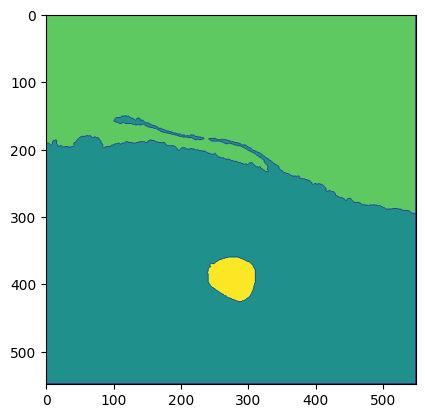

In [7]:
for path in batch_1:
    print(path)
    name = get_patient_name(path)
    all_names.append(name)

    test_res = calc_analyze_plus(path,0,1)
    if len(all_names)>2 and name == all_names[-2]:
        print(name)

        all_areas_med[-1].append(test_res[0][0])
        all_bckgrnd_med[-1].append(test_res[1])
        all_dist_med[-1].append(test_res[2][0])
        all_flt_med[-1].append(test_res[3][0])

    else:
        patient_names.append(name)
        all_areas_med.append(test_res[0][0])
        all_bckgrnd_med.append(test_res[1])
        all_dist_med.append(test_res[2][0])
        all_flt_med.append(test_res[3][0])

for path in batch_2:
    print(path)
    name = get_patient_name(path)
    all_names.append(name)

    test_res = calc_analyze_plus(path,0,1)
    if len(all_names)>2 and name == all_names[-2]:
        print(name)

        all_areas_med[-1].append(test_res[0][0])
        all_bckgrnd_med[-1].append(test_res[1])
        all_dist_med[-1].append(test_res[2][0])
        all_flt_med[-1].append(test_res[3][0])

    else:
        patient_names.append(name)
        all_areas_med.append(test_res[0][0])
        all_bckgrnd_med.append(test_res[1])
        all_dist_med.append(test_res[2][0])
        all_flt_med.append(test_res[3][0])

# FOR ALL DATA
pac_means['patient_name'] = patient_names
pac_means['areas'] = all_areas_med
pac_means['background'] = all_bckgrnd_med
pac_means['distants'] = all_dist_med
pac_means['flatness'] = all_flt_med

In [8]:
pac_means

,patient_name,areas,background,distants,flatness
0,081,"[739, 610, 2874, 4478, 3018, 4048, 2321, 4656,...",[38313],"[41.7612260356422, 151.0132444522665, 232.2154...","[0.5293683295052156, 0.49630525546220755, 0.67..."
1,062,"[25216, 4188, 6095, 1542, 10258, 5595, 1531, 6...",[25216],"[194.67151820438448, 207.03864373589778, 168.7...","[0.7070402261033385, 0.28536773099813534, 0.78..."
2,053,"[5356, 2714, 3791, 3232, 1772, 705, 5442, 664,...",[44441],"[77.20103626247513, 136.7186892857008, 202.891...","[0.6610527252355165, 0.7575655114377, 0.740613..."
3,082,"[21361, 5104, 5072, 2391, 1039, 2672, 6512, 12...",[21361],"[212.00235847744713, 204.59227746911662, 176.9...","[0.8337384596747774, 0.5572314564035804, 0.153..."
4,015,"[758, 21482, 1471, 2561, 3313, 2454, 1150, 224...",[123395],"[332.4484922510553, 146.10954794263105, 227.05...","[0.3346330134501553, 0.1586188946844464, 0.427..."
...,...,...,...,...,...
111,10-1106_A1,"[675, 512, 895, 2465, 4324, 2460, 5033, 3130, ...",[141343],"[35.22782990761707, 71.02816342831905, 140.356...","[0.8183047307687908, 0.6338430825461725, 0.819..."
112,C18-30756_A1,"[731, 874, 649, 1303, 11921, 571, 4475, 5696, ...",[49102],"[107.22872749408155, 172.02616080119907, 291.1...","[0.6619528177523558, 0.918257953069215, 0.3647..."
113,C18-30758_A1,"[588, 1668, 2935, 515, 1483, 559, 1132, 1567, ...",[121526],"[34.539832078341085, 58.05170109479997, 127.34...","[0.8002191246821357, 0.7311477242425742, 0.865..."
114,C18-30760_A2,"[1235, 1164, 1327, 1481, 2269, 3534, 3210, 228...",[103287],"[269.02973813316623, 327.00152904841286, 208.2...","[0.20455151806052574, 0.40793355377291196, 0.8..."


In [9]:
def vals_to_list(row):
    vals = []
    for i, val in enumerate(row):
        if isinstance(val, list) :
            for i2, val2 in enumerate(val):
                vals.append(val)
        else :
            vals.append(val)

    return vals


In [10]:
pac_means['areas'] = pac_means['areas'].apply(vals_to_list)
pac_means['background'] = pac_means['background'].apply(vals_to_list)
pac_means['distants'] = pac_means['distants'].apply(vals_to_list)
pac_means['flatness'] = pac_means['flatness'].apply(vals_to_list)

In [11]:
pac_means.to_csv('/content/drive/MyDrive/FAT_CELLS/Pac_features.csv')